In [4]:
import os
from random import random
from pyparsing import results
!pip install mediapipe opencv-python

In [5]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose ## Model for pose estimation

# Test mediapipe

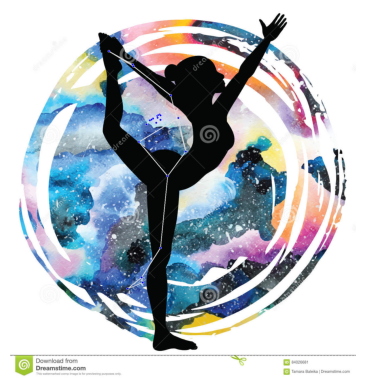

In [5]:
import os
import random
import matplotlib.pyplot as plt

# Assuming you have already imported mediapipe as mp

folder_path = "Train"

images = os.listdir(folder_path)
random_image = random.choice(images)
random_image_path = os.path.join(folder_path, random_image)

# Image automatically change to RGB.
image = cv2.imread(random_image_path)

image.flags.writeable = False

# Make detection
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
result = pose.process(image)

# Recolor back to BGR
image.flags.writeable = True
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Render detections
mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

# Display the result
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

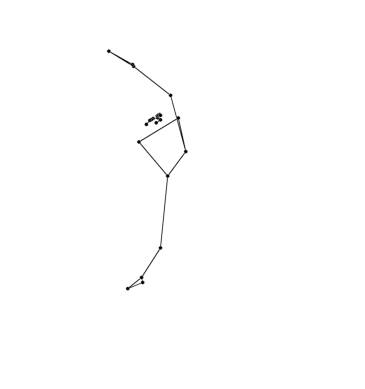

In [6]:

# Create a white background image with the same size as the original image
white_background = np.ones_like(image) * 255

# Make the white background image writeable
white_background.flags.writeable = True

# Render detections on the white background with specified colors
mp_drawing = mp.solutions.drawing_utils
mp_drawing.draw_landmarks(
    white_background, result.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=4, circle_radius=4),
    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=2)
)

# Convert the white background image to BGR for display
white_background_bgr = cv2.cvtColor(white_background, cv2.COLOR_RGB2BGR)

# Display the result
plt.imshow(white_background_bgr)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()


0.28554567694664 0.1137385442852974 0.509719967842102 0.7554023861885071


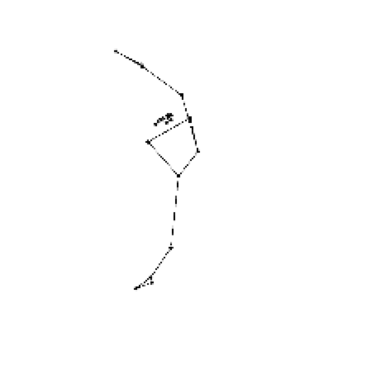

In [7]:
# Get landmarks of the detected pose
landmarks = result.pose_landmarks.landmark if result.pose_landmarks else []

# Extract x, y coordinates of landmarks
landmark_coords = np.array([(lm.x, lm.y) for lm in landmarks])

# Find the bounding box that encloses the detected skeleton
min_x, min_y = np.min(landmark_coords, axis=0)
max_x, max_y = np.max(landmark_coords, axis=0)

print(min_x,min_y,max_x,max_y)

# Add 5-pixel margins to the bounding box
margin = 5
min_x -= margin
min_y -= margin
max_x += margin
max_y += margin

# Crop the image based on the bounding box
cropped_image = white_background_bgr[int(min_y * white_background_bgr.shape[0]):int(max_y * white_background_bgr.shape[0]),
                int(min_x * white_background_bgr.shape[1]):int(max_x * white_background_bgr.shape[1])]

# Resize the cropped image to a consistent size (e.g., 224x224 for classification)
resized_image = cv2.resize(cropped_image, (224, 224))


plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Prepare for classification

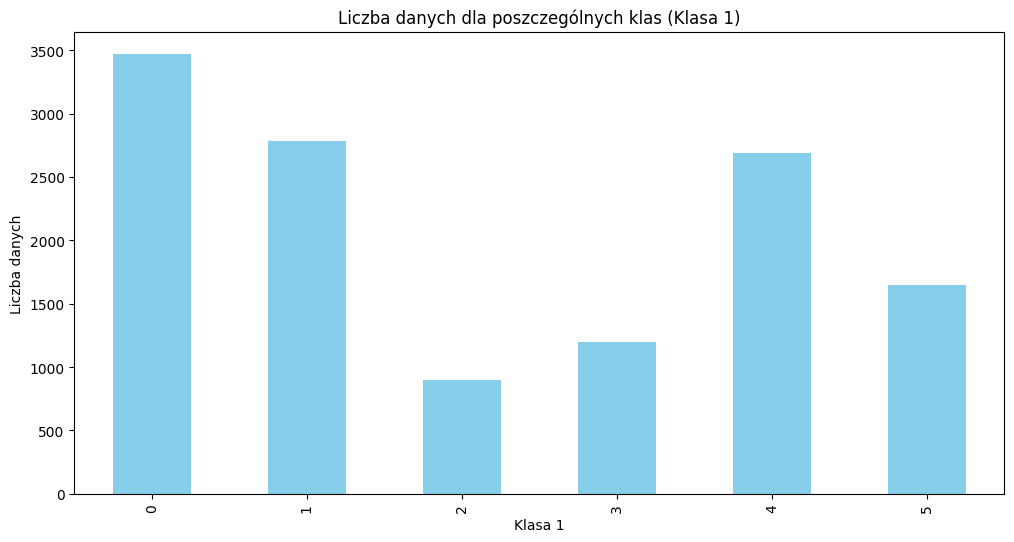

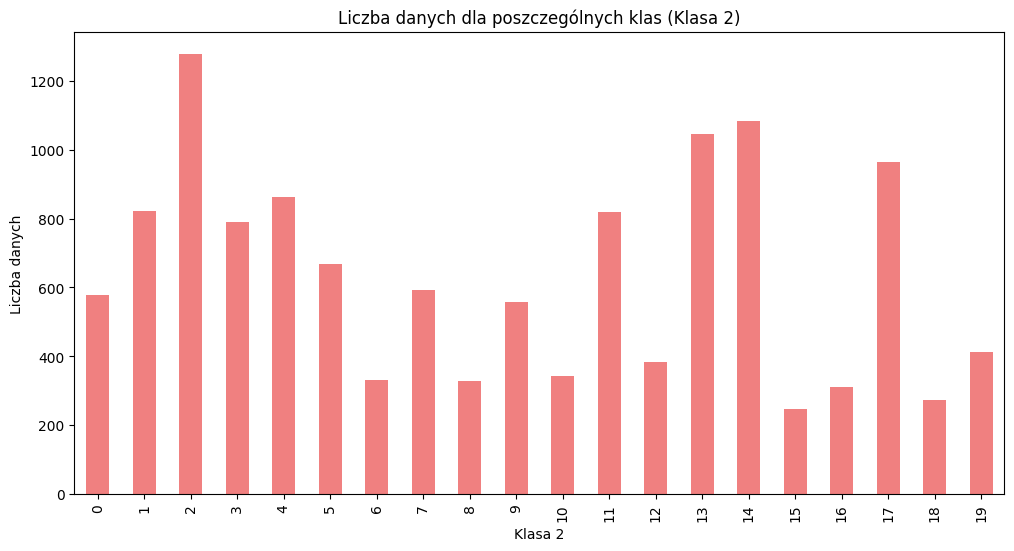

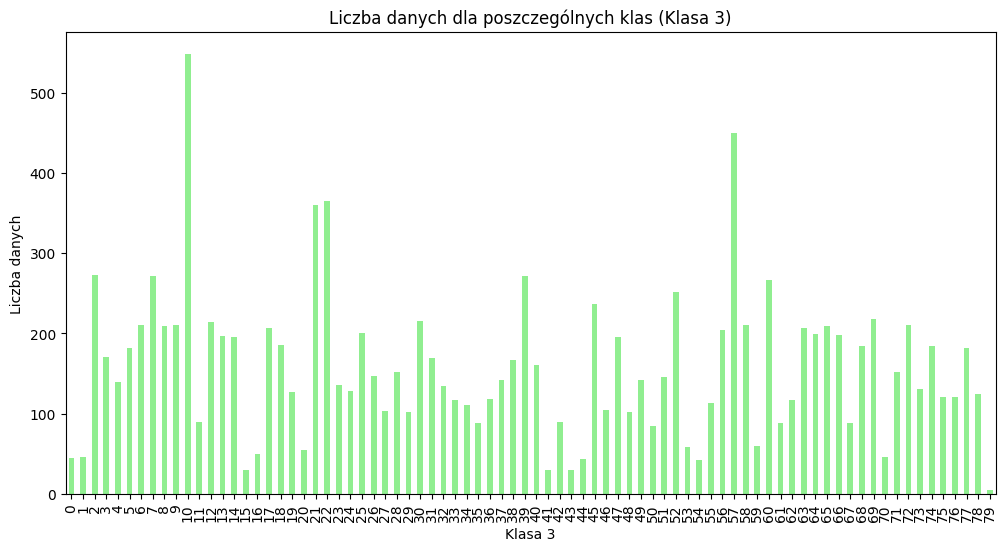

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')


df['Class1'], df['Class2'], df['Class3'] = zip(*df['PoseLabel'].apply(lambda x: map(int, x.split('_'))))

# Klasa 1
plt.figure(figsize=(12, 6))
df['Class1'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Liczba danych dla poszczególnych klas (Klasa 1)')
plt.xlabel('Klasa 1')
plt.ylabel('Liczba danych')
plt.show()

# klasa 2
plt.figure(figsize=(12, 6))
df['Class2'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title('Liczba danych dla poszczególnych klas (Klasa 2)')
plt.xlabel('Klasa 2')
plt.ylabel('Liczba danych')
plt.show()

# klasa 3
plt.figure(figsize=(12, 6))
df['Class3'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Liczba danych dla poszczególnych klas (Klasa 3)')
plt.xlabel('Klasa 3')
plt.ylabel('Liczba danych')
plt.show()

## Custom Dataset

00021.jpg
torch.Size([1, 224, 224])
Label: 0
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Minimum value: 0.0
Maximum value: 1.0


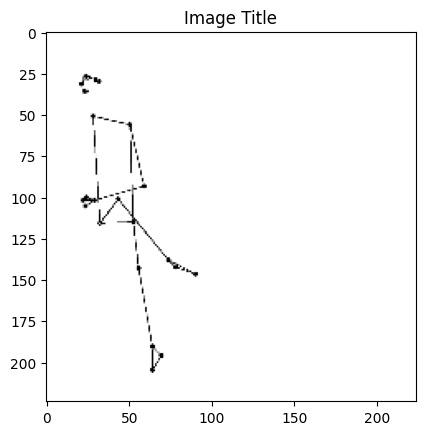

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt


class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.transform = transforms.Compose([
            self.custom_transform,   # Apply custom transformation
            transforms.ToPILImage(),  # Convert to PIL Image
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale, not sure if needed.
            transforms.ToTensor(),
        ])

    def custom_transform(self, image):
        mp_pose = mp.solutions.pose
        
        # Make detection
        image.flags.writeable = False
        pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
        result = pose.process(image)

        # Create a white background image with the same size as the original image
        white_background = np.ones_like(image) * 255

        # Make the white background image writeable
        white_background.flags.writeable = True
    
        # Render detections on the white background with specified colors
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing.draw_landmarks(
            white_background, result.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=4, circle_radius=4),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=2)
        )
        white_background_bgr = cv2.cvtColor(white_background, cv2.COLOR_RGB2BGR)

        # Get landmarks of the detected pose
        landmarks = result.pose_landmarks.landmark if result.pose_landmarks else []

        # Extract x, y coordinates of landmarks
        landmark_coords = np.array([(lm.x, lm.y) for lm in landmarks])
        
        if landmark_coords.size > 0:
            # Find the bounding box that encloses the detected skeleton
            min_x, min_y = np.min(landmark_coords, axis=0)
            max_x, max_y = np.max(landmark_coords, axis=0)
        
            # Add 5-pixel margins to the bounding box
            margin = 5
            min_x -= margin
            min_y -= margin
            max_x += margin
            max_y += margin
        
            # Crop the image based on the bounding box
            cropped_image = white_background_bgr[int(min_y * white_background_bgr.shape[0]):int(max_y * white_background_bgr.shape[0]),
                            int(min_x * white_background_bgr.shape[1]):int(max_x * white_background_bgr.shape[1])]
        
            # Resize the cropped image to a consistent size (e.g., 224x224 for classification)
            resized_image = cv2.resize(cropped_image, (224, 224))
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)

            return resized_image
        else:
            # Handle the case where no pose landmarks are detected
            return np.zeros((224, 224), dtype=np.uint8)  # You can adjust the default image as needed

    def get_label(self, img_name):
        # Extract the label from the image name (assuming it's the first digit)
        label = int(img_name[0])  # Convert the first character to an integer
        return label

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = cv2.imread(img_name)  # Read image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        tensor_image = self.transform(image)
        label = self.get_label(self.image_files[idx])

        # Save the preprocessed image to the "NewTrain" folder
        save_path = os.path.join("NewTrain", f"preprocessed_{self.image_files[idx]}")
        if tensor_image.shape[0] == 1:
            # If it's a single-channel image, convert it to three channels before saving
            tensor_image_rgb = torch.cat([tensor_image] * 3, dim=0)
            cv2.imwrite(save_path, cv2.cvtColor(tensor_image_rgb.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2BGR))
        else:
            # If it's already a three-channel image, save as is
            cv2.imwrite(save_path, cv2.cvtColor(tensor_image.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2BGR))


        return tensor_image, label

# Example usage:
data_directory = "Train"
custom_dataset = CustomDataset(data_directory)

# Example loading one image
sample_image, label = custom_dataset[2]
file = os.listdir(data_directory)
print(file[2])
print(sample_image.shape)  # Check the shape (should be torch.Size([1, 224, 224]))
print("Label:", label)
print(sample_image)

min_value = torch.min(sample_image)
max_value = torch.max(sample_image)

print("Minimum value:", min_value.item())
print("Maximum value:", max_value.item())

# Convert the tensor to a NumPy array
numpy_image = sample_image.squeeze().numpy()

# Display the image
plt.imshow(numpy_image, cmap='gray')  # Use 'gray' colormap for single-channel images
plt.title("Image Title")
plt.show()

In [4]:
custom_dataset.__len__()

12690

In [ ]:
unique_labels = set()
from torch.utils.data import DataLoader
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

for batch_images, batch_labels in data_loader:
    # Print a message for each batch processed
    print(f"Processing batch with labels: {batch_labels.tolist()}")

    # Update unique_labels set with batch labels
    unique_labels.update(batch_labels.tolist())

# Print a final message after the loop completes
print("Unique labels in the dataset:", unique_labels)

Processing batch with labels: [5, 3, 4, 2, 2, 5, 5, 1]
Processing batch with labels: [3, 1, 4, 1, 1, 1, 2, 0]
Processing batch with labels: [1, 1, 7, 2, 1, 0, 3, 0]
Processing batch with labels: [6, 2, 5, 4, 1, 3, 5, 5]
Processing batch with labels: [6, 7, 5, 3, 0, 0, 5, 0]
Processing batch with labels: [0, 6, 2, 3, 7, 0, 6, 1]
Processing batch with labels: [1, 6, 3, 1, 3, 4, 1, 1]
Processing batch with labels: [2, 0, 0, 3, 2, 1, 1, 1]
Processing batch with labels: [3, 4, 2, 4, 7, 7, 4, 5]
Processing batch with labels: [5, 7, 5, 7, 5, 7, 5, 6]


In [3]:
print(type(custom_dataset))

print(custom_dataset[2000])

<class '__main__.CustomDataset'>
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 1)


## Model for first level - ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models

train_size = int (0.7 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset,val_dataset = torch.utils.data.random_split(custom_dataset,[train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 8 last layer to be trainable
for param in model.layer4.parameters():
    param.requires_grad = True
    
model.train()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
epochs = 10
for epoch in range(epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        accuracy = correct / total
        print(f'Epoch {epoch + 1}/{epochs}, Validation Accuracy: {accuracy * 100:.2f}%')

# Save the fine-tuned model if needed
torch.save(model.state_dict(), 'fine_tuned_resnet18.pth')


## Angles

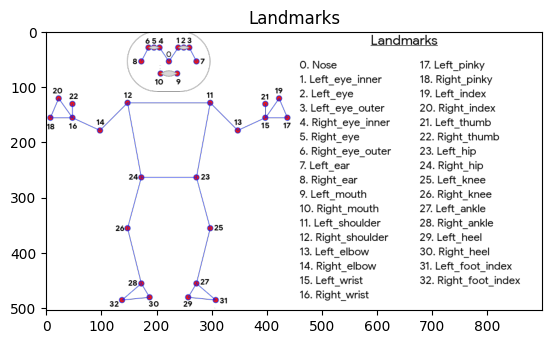

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('landmarks-fixed.png')

plt.imshow(img)
plt.title("Landmarks")
plt.show()

In [6]:
import numpy as np

def calculate_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if(angle > 180):
        angle = 360 - angle
    
    return angle

Angle: 169.59904764798205


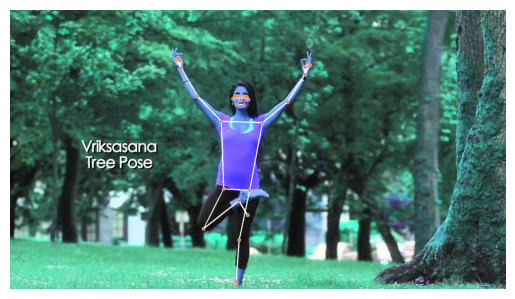

In [8]:
import os
import random
import matplotlib.pyplot as plt

# Assuming you have already imported mediapipe as mp

folder_path = "Train"

images = os.listdir(folder_path)
random_image = random.choice(images)
random_image_path = os.path.join(folder_path, random_image)

image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image.flags.writeable = False

# Make detection
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
result = pose.process(image)

# Recolor back to BGR
image.flags.writeable = True
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

try:
    landmarks = result.pose_landmarks.landmark

    shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

    angle = calculate_angle(shoulder, elbow, wrist)
    print("Angle:", angle)
except:
    pass

# Render detections
mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                          mp_drawing.DrawingSpec(color=(245,117,66)),
                          mp_drawing.DrawingSpec(color=(255,255,255))
                          )

# Display the result
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [1]:
# Important angels